In [34]:
# Import internal libraries
import json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [35]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data"
refdir = "../lfsr"
for bpc in range(2, 3):
    refvec = np.loadtxt(f"{refdir}/lfsr_tb_vecgen_{bpc-1}.txt", delimiter=',', dtype=np.int8)
    # for alias in ["ispp10", "ispp12", "ispp13", "ispp14", "ispp15", "ispp16", "ispp17", "ispp18", "ispp19",
    # for alias in ["ispp20", "ispp21", "ispp22", "ispp23", "ispp24", "ispp25", "ispp26", "ispp27", "ispp28"]:
    # for alias in ["ispp25", "ispp26", "ispp27", "ispp28", "ispp29", "ispp30", "ispp31"]:
    for alias in ["ispp2", "ispp3", "ispp4", "ispp5", "ispp6", "ispp7", "ispp8", "ispp9"]:
        for att in [1, 2, 4, 8] + list(range(16, 256, 32)):
            # Real max attempts
            att = (att & 31) << (att >> 5)

            # Load and compute data
            try:
                diag = json.load(open(f"{datadir}/diag_{bpc}bpc_{alias}_{att}.json"))
                dt = np.loadtxt(f"{datadir}/dt_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                # ivdd_and_dac = np.loadtxt(f"{datadir}/vdd_and_dac_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                # ivsa = np.loadtxt(f"{datadir}/vsa_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                # ivddio = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                # ivddio_dac = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
            except OSError:
                continue
            power_tot = 0 #ivdd_and_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
            dt2 = diag["cycles"] * 1e-8
            energy_tot = power_tot * dt2
            bw = 2**16 * 48 * bpc / dt2 # bits per second
            energy_per_bit = energy_tot / 2**16 / 48 / bpc
            edp = energy_per_bit / bw

            # Load data into confmat
            try:
                confmat = np.loadtxt(f"{datadir}/confmat_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
            except OSError:
                try:
                    postread = np.loadtxt(f"{datadir}/postread_{bpc}bpc_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                    confmat = np.zeros(shape=(2**bpc, 2**bpc))
                    for i in range(65535):
                        for j in range(48):
                            if j in [7, 16, 19, 23, 24, 29, 38, 39, 43]: #[16, 19,24,29,38,43]:
                                continue
                            confmat[refvec[i][j]][postread[i][j]] += 1
                    confmat = confmat.astype(int)
                    np.savetxt(f"{datadir}/confmat_{bpc}bpc_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                    print(confmat)
                except OSError:
                    continue

            # Symbol error magnitudes
            mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
            rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

            # Function to get Gray code string
            getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

            # Function to get Gray code error rate for each possible symbol confusion
            grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

            # BER and CER
            ber = (grayerr * confmat).sum() / confmat.sum()
            cer = 1 - confmat.trace() / confmat.sum()
            
            # Compose dataframe
            d = {"alias": alias, "att": att, "bpc": bpc, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
            d.update(diag)
            data.append(d)
data = pd.DataFrame(data)
data

[[434617  23397  31296 149571]
 [272474 191222  23737 151066]
 [159671 160197 146750 172794]
 [     2    202 136788 502081]]
[[505790  11560  21286 100245]
 [310604 189086  22767 116042]
 [170199 171344 169430 128439]
 [     3     22  70821 568227]]
[[604110   8200   8142  18429]
 [385624 205919  14288  32668]
 [213637 208438 179375  37962]
 [     3      1  23758 615311]]
[[636367   1703    362    449]
 [277330 354352   3479   3338]
 [137793 302502 181964  17153]
 [     0      0   4656 634417]]
[[637365   1100    187    229]
 [103648 530336   3251   1264]
 [ 18035  56346 489193  75838]
 [     0      0   2612 636461]]
[[637985    724     83     89]
 [ 20769 614429   2803    498]
 [  8132  14823 507701 108756]
 [     0      0   2144 636929]]
[[638400    421     33     27]
 [  5854 630200   2271    174]
 [  3628   8162 514677 112945]
 [     0      0   2020 637053]]
[[638597    262     14      8]
 [  2598 633849   1987     65]
 [  1421   5841 517976 114174]
 [     0      0   2084 636989]]


,alias,att,bpc,dt,power_tot,energy_per_bit,edp,bw,cer,ber,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,ispp2,1,2,0.14450407028198242,0,0.0,0.0,4.368921e+07,0.612020,0.390917,...,1.255964,65536,262115,596593,72305,189810,14400479,3247708,684342,945573
1,ispp2,2,2,0.23717427253723145,0,0.0,0.0,2.654955e+07,0.524370,0.327229,...,1.083025,65536,261894,858622,143812,380196,23697033,4874415,1208875,1757579
2,ispp2,4,2,0.6172726154327393,0,0.0,0.0,1.019969e+07,0.426209,0.267291,...,0.890767,65536,257676,1414570,328491,713923,61682826,7624899,2419557,2687552
3,ispp2,8,2,2.653787612915039,0,0.0,0.0,2.371056e+06,0.358240,0.214850,...,0.757213,65536,207127,2473104,994175,963630,265344103,13749323,6652654,3254357
4,ispp2,16,2,3.711412191390991,0,0.0,0.0,1.695297e+06,0.131293,0.070235,...,0.398867,65536,150858,3911492,2043992,1239971,371112282,21671560,12607656,3586488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,ispp9,128,2,20.167574644088745,0,0.0,0.0,3.119681e+05,0.050259,0.025423,...,0.228132,65536,16693,7822389,2574333,4296583,2016698663,29710878,12960945,7365951
92,ispp9,256,2,27.01488947868347,0,0.0,0.0,2.328939e+05,0.049480,0.024837,...,0.223760,65536,10498,9337740,2595094,5783895,2701426163,31517422,13047626,9003153
93,ispp9,512,2,35.612977504730225,0,0.0,0.0,1.766656e+05,0.049046,0.024551,...,0.221854,65536,6392,11182826,2602415,7617367,3561222752,33532198,13080000,10937418
94,ispp9,1024,2,45.65810990333557,0,0.0,0.0,1.377984e+05,0.048769,0.024397,...,0.221028,65536,3680,13358148,2607482,9785916,4565695244,35799580,13088913,13175897


/tmp/ipykernel_21819/3614265500.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[2].set_yscale("log")
/tmp/ipykernel_21819/3614265500.py:32: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


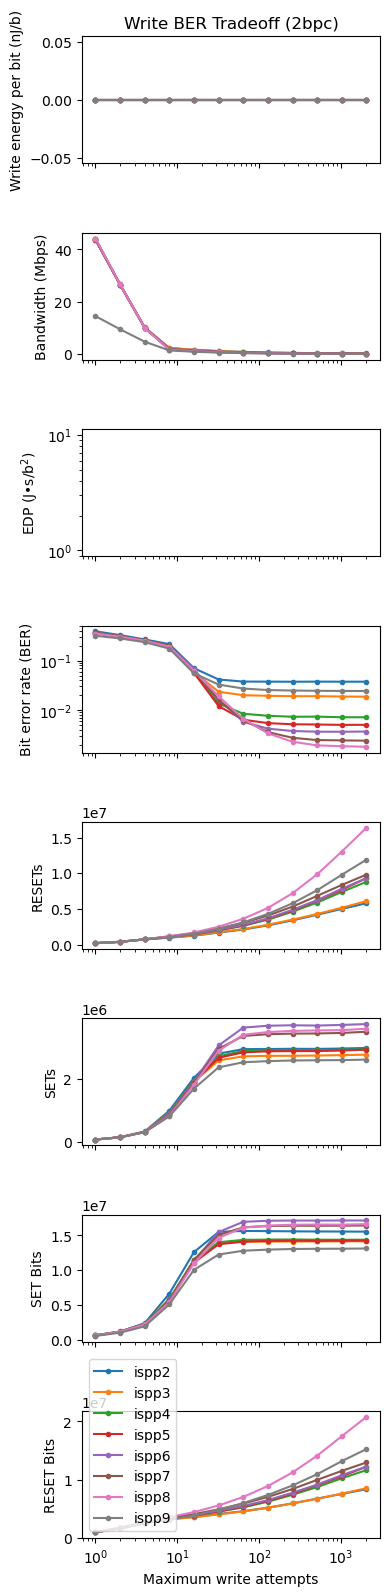

In [36]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(8, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
    plt.xlabel("Maximum write attempts")
    plt.xscale("log")
    axs[0].set_title(f"Write BER Tradeoff ({bpc}bpc)")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
    # axs[0].set_yscale("log")
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
    # axs[1].set_yscale("log")
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["edp"], ".-", label=alias)
    axs[2].set_yscale("log")
    axs[2].set_ylabel("EDP (J•s/b$^2$)")
    axs[3].plot(d["att"], d["ber"], ".-", label=alias)
    axs[3].set_yscale("log")
    axs[3].set_ylabel("Bit error rate (BER)")
    axs[4].plot(d["att"], d["resets"], ".-", label=alias)
    # axs[4].set_yscale("log")
    axs[4].set_ylabel("RESETs")
    axs[5].plot(d["att"], d["sets"], ".-", label=alias)
    # axs[5].set_yscale("log")
    axs[5].set_ylabel("SETs")
    axs[6].plot(d["att"], d["set_bits"], ".-", label=alias)
    # axs[6].set_yscale("log")
    axs[6].set_ylabel("SET Bits")
    axs[7].plot(d["att"], d["reset_bits"], ".-", label=alias)
    # axs[7].set_yscale("log")
    axs[7].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.show()